<a href="https://colab.research.google.com/github/jose51igual/HackingNotes/blob/main/Proyecto_1_RNA_para_clasificacion_de_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

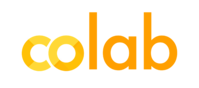
<br>
[Abre este Notebook en Google Colab](https://colab.research.google.com/drive/1iYwyCMXi14Ql577dC-RuoP2eJXErgsMb?usp=sharing)

# Introducción a Keras: Implementando una RNA para clasificación de imágenes

## Implementación de una Red Neuronal Artificial con Keras

Cuando abordamos la implementación de una Red Neuronal Artificial profunda utilizando Keras, debemos tener en cuenta los siguientes puntos:

1. Prepara tu conjunto de datos de entrenamiento: vectores de entrada y de salida
2. Define la arquitectura de la Red Neuronal Artificial
3. Configura el proceso de aprendizaje mediante la seleccion de una funcion de error, una funcion de optimizacion y diferentes metricas para monitorizar el proceso
4. Entrena la RNA con tu conjunto de datos de entrenamiento mediante el uso del metodo `fit()`
5. Realiza predicciones (inferencia) para nuevos ejemplos que no estaban en los conjuntos de datos de entrenamiento

## 0. Importar librerías externas

Lo primero que debe hacerse es importar las librerías específicas necesarias para la implementación de la Red Neuronal Artificial. En este caso, el framework que vamos a utilizar es Keras.

La última versión de Keras puede instalarse mediante el paquete `keras-core`.

In [1]:
!pip install keras-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.6 MB/s eta 0:00:00


Con la nueva versión de Keras podemos selccionar el backend que queremos utilizar. Por defecto se selecciona `tensorflow`, sin embargo, tenemos disponibles otros backends como `pytorch` o `jax`.

El backend debe configurarse antes de importar Keras y no puede cambiarse después de la importación.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

Importamos Keras con el backend seleccionado

In [3]:
import keras_core

Using PyTorch backend.


Otra opción es utilizar Keras directamente desde el framework Tensorflow. Si el backend que vamos a utilizar es Tensorflow, esta opción está más optimizada y suele proporcionar mejores resultados.

Tanto Keras-core como la versión de Keras que se encuentra en framework Tensorflow son totalmente compatibles y no requieren modificaciones en la implementación del programa.

In [4]:
from tensorflow import keras

Verificamos si el backend (Tensorflow) esta utilizando la GPU

In [5]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

## 1. Preparación del conjunto de datos de entrenamiento

### 1.1. Importando el conjunto de datos

Descargamos el conjunto de datos de imágenes. En este caso práctico vamos a hacer uso del conjunto de datos "Dogs vs Cats" de Kaggle.

El conjunto de datos contiene 25.000 imágenes de perros y gatos. El objetivo es entrenar una RNA profunda utilizando estos archivos para que sea capaz de clasificar nuevas imágenes en función de si aparece un perro o un gato en ella.

In [6]:
# Descargamos el conjunto de datos en el almacenamiento temporal de Google Colab
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

# Descomprimimos el conjunto de datos
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  79.2M      0  0:00:09  0:00:09 --:--:-- 88.3M


Si queremos guardar el conjunto de datos en almacenamiento persistente debemos conectar Google Colab con Google Drive.

In [ ]:
# Montamos nuestro GDrive en Google Colab
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Guardamos el conjunto de datos en el almacenamiento persistente de Google Drive
!unzip -d /content/drive/MyDrive/curso_LinkedIn kagglecatsanddogs_5340.zip

### BONUS: ¿De dónde podemos obtener conjuntos de datos interesantes?
- Kaggle: https://www.kaggle.com/datasets
- Hugging Face: https://huggingface.co/datasets

### 1.2. Limpieza de los datos

Cuando trabajamos con conjuntos de datos reales, es muy frecuente que algunos de los ejemplos esten corruptos o incompletos y haya que eliminarlos.

En este caso concreto, debemos recorrer el conjunto de datos buscando imágenes que no se encuentren en el formato adecuado.

In [7]:
# Ruta del conjunto de datos
DATASET_PATH = "/content/PetImages"

In [8]:
import tensorflow as tf
import os

def filter_images():
  deleted_imgs = 0
  for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(DATASET_PATH, folder_name)
    for image in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image)
        try:
            fobj = open(img_path, "rb")
            # Comprobamos si la imagen esta en formato JPEG
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            deleted_imgs += 1
            # Eliminamos la imagen correspondiente
            os.remove(img_path)
  print(f"Imágenes eliminadas: {deleted_imgs}")

In [9]:
filter_images()

Imágenes eliminadas: 1590


### 1.3. Creación de un Dataset con Keras

Otro de los aspectos importantes cuando utilizamos un conjunto de datos de imágenes es normalizar su tamaño. Lo habitual cuando trabajamos con imágenes reales es que tengan diferentes tamaños.

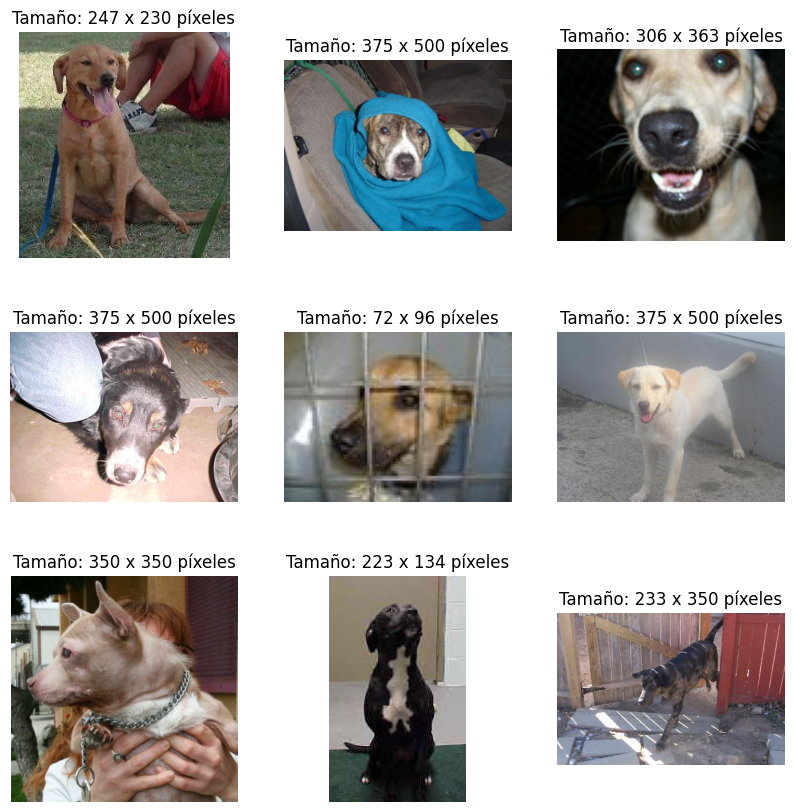

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plt.figure(figsize=(10, 10))

folder_path = os.path.join(DATASET_PATH, "Dog")
for i, image in enumerate(os.listdir(folder_path)[:9]):
  img_path = os.path.join(folder_path, image)
  img = mpimg.imread(img_path)
  ax = plt.subplot(3, 3, i + 1) # (nrows, ncols, index)
  plt.imshow(img)
  plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} píxeles")
  plt.axis("off")

plt.show()

Keras nos permite normalizar el tamaño de las imágenes de nuestro conjunto de datos haciendo uso de funciones auxiliares que convierten los datos a un objeto Dataset de los diferentes backends que estemos utilizando.

Tensorflow: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [11]:
image_size = (180, 180)
batch_size = 128 # Tamaño de lote

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,  # 20% de los datos forman parte del subconjunto de validación
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


Podemos observar que las imágenes tienen el mismo tamaño.

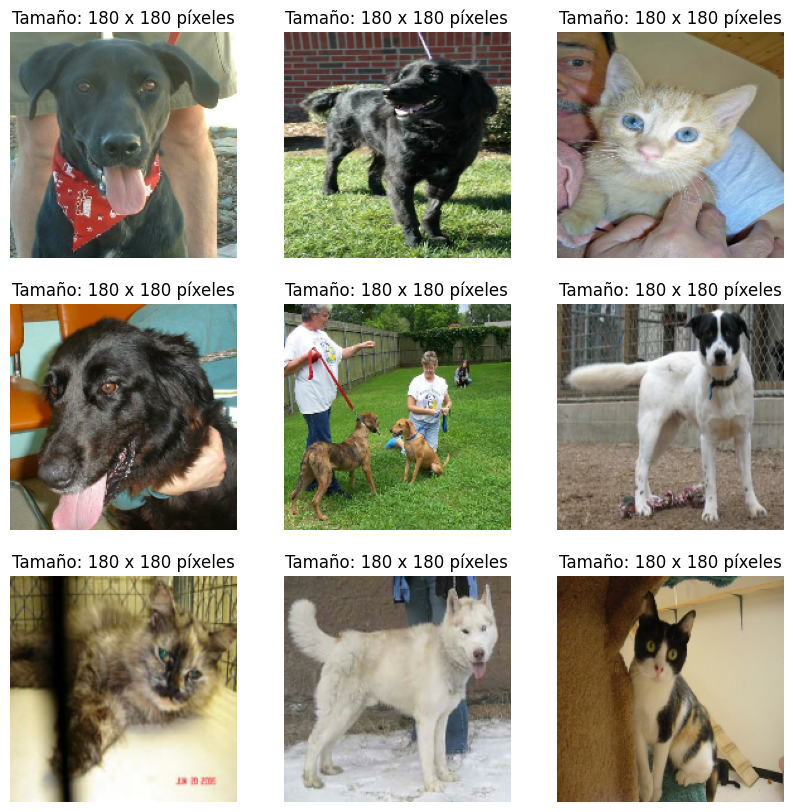

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1): # take(1) obtiene un lote del conjunto de datos (128 ejemplos)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Tamaño: {images[i].shape[0]} x {images[i].shape[1]} píxeles")
        plt.axis("off")

plt.show()

### 1.4. Separación de la etiqueta (label)

Por norma general, las redes neuronales artificiales profundas suelen corresponderse con técnicas de Machine Learning basadas en **aprendizaje supervisado**.

Esto quiere decir, que durante el proceso de entrenamiento o aprendizaje van a requerir un **conjunto de datos etiquetado**.

Un conjunto de datos etiquetado se caracteriza porque esta formado por los elementos de entrada (en este caso las imágenes) y los elementos de salida o etiqueta (en este caso el valor `0` si aparece un gato en la imágene y `1` si aparece un perro).

El objetivo de la RNA es aprender lo suficiente del conjunto de datos de entrenamiento para poder recibir imágenes que no se encuentran en el conjunto de datos y predecir de manera autónoma la etiqueta.

La función de Keras que hemos utilizado anteriormente ha etiquetado las imágenes en función de la carpeta en la que se encontraban.

In [13]:
# El conjunto de datos de entrenamiento esta formado por 147 batches
len(train_ds)

147

In [14]:
# Cada batch esta formado por 128 imágenes y sus correspondientes etiquetas
batch1 = list(train_ds.take(1))
batch1

[(<tf.Tensor: shape=(128, 180, 180, 3), dtype=float32, numpy=
  array([[[[ 22.023148,  19.023148,  12.023149],
           [ 22.180555,  19.180555,  12.180555],
           [ 22.393517,  19.393517,  12.393516],
           ...,
           [ 59.444458,  42.444458,  24.444458],
           [ 55.000183,  38.66681 ,  20.333496],
           [ 55.111084,  40.111084,  21.111084]],
  
          [[ 27.958334,  24.958334,  17.958334],
           [ 21.916666,  18.916666,  11.916666],
           [ 22.347221,  19.347221,  12.347221],
           ...,
           [ 59.444458,  42.444458,  24.444458],
           [ 55.000183,  38.66681 ,  20.333496],
           [ 55.77774 ,  40.77774 ,  21.77774 ]],
  
          [[ 34.77778 ,  31.777779,  24.777777],
           [ 18.583334,  15.583334,   8.583334],
           [ 20.185186,  17.185186,  10.185186],
           ...,
           [ 59.444458,  42.444458,  24.444458],
           [ 55.333496,  39.000122,  20.66681 ],
           [ 56.222168,  41.222168,  22.222168]],

In [15]:
print(f"Número de imágenes en el batch: {len(batch1[0][0])}")
print(f"Etiquetas del batch: {batch1[0][1]}")

Número de imágenes en el batch: 128
Etiquetas del batch: [0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1
 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0
 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0]


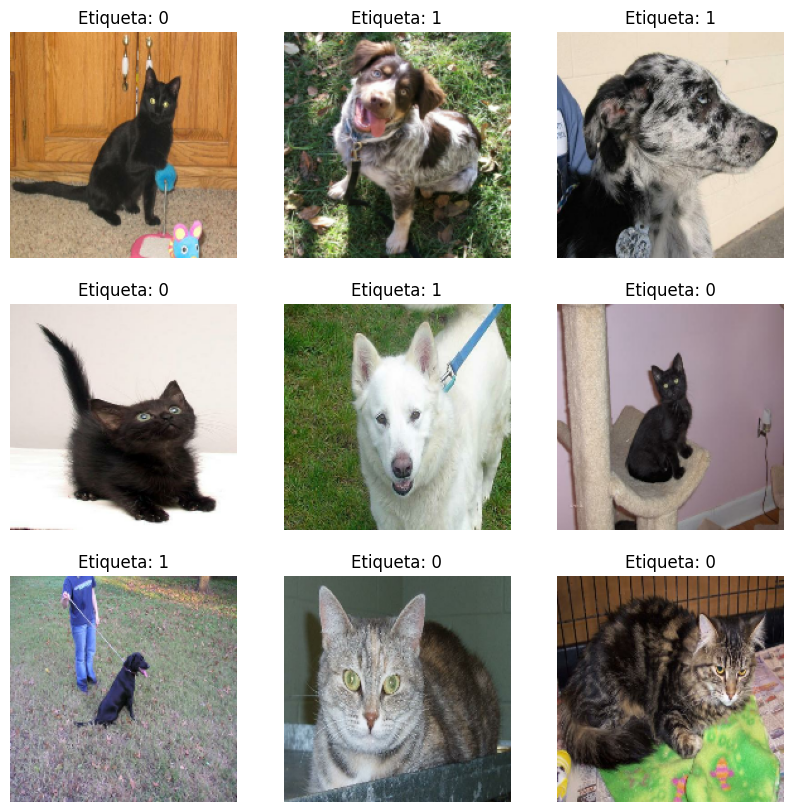

In [16]:
# Mostramos dos imágenes del batch con su etiqueta
plt.figure(figsize=(10, 10))

for img, etiqueta in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(f"Etiqueta: {etiqueta[i]}")
    plt.axis("off")

plt.show()

### 1.5. División del conjunto de datos

Cuando abordamos la resolución de un problema real aplicando Inteligencia Artificial / Machine Learning / Deep Learning, debemos dividir el conjunto de datos en 3 subconjuntos:
* **Subconjunto de entrenamiento** (`train_ds`): Contiene apróximadamente el 60-80% de los datos. Este subcojunto se utiliza para entrenar el algoritmo.
* **Subconjunto de validación** (`val_ds`): Contiene apróximadamente el 10-20% de los datos. Este subcojunto se utiliza para validar el comportamiento del algoritmo durante el proceso de entrenamiento.
* **Subconjunto de pruebas** (`test_ds`): Contiene apróximadamente el 10-20% de los datos. Este subconjunto se utilizar para validar el comportamiento del algoritmo entrenado final. Su función es determinar si el modelo se comporta correctamente para ejemplos que no ha visto nunca.

Esta división y modo de actuar nos permite evitar problemas graves como el sobreentrenamiento u _overfitting_.

Keras nos permite dividir de manera muy sencilla el conjunto de datos en el subconjunto de entrenamiento y validación.

In [17]:
# Obtenemos el suconjunto de validación
temp_val_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,  # 20% de los datos forman parte del subconjunto de validación
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Ahora que ya tenemos el subconjunto de validación formado por el 20% de los datos de nuestro conjunto de datos, vamos a subdividirlo en el conjunto de validación y pruebas.

In [18]:
len(temp_val_ds)

37

In [19]:
# 50% de los datos formarán parte del subconjunto de validación y 50% del de pruebas
val_size = int(0.5 * len(temp_val_ds))

In [20]:
val_size

18

In [21]:
val_ds = temp_val_ds.take(val_size)
test_ds = temp_val_ds.skip(val_size)

In [22]:
len(val_ds)

18

In [23]:
len(test_ds)

19

Existen otras formas más específicas de dividir el conjunto de datos si necesitamos aplicar transformaciones concretas.

Una de las mejores funciones que hay para realizar esta tarea es `train_test_split` de Sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Idealmente se debe abordar esta fase de división del conjunto de datos con precisión y rigurosidad. Puede ser una fase separada de la implementación del ejercicio y debe buscarse la manera de que la división no afecte a la tendencia del conjunto de datos.

In [24]:
# train_test_split no puede trabajar con objetos Dataset de Tensorflow
# Esto supone un incremento del consumo de memoria RAM
val_ds_sk = list(temp_val_ds)

In [ ]:
from sklearn.model_selection import train_test_split

# División del conjunto de validación en validación y prueba
val_ds_sk, test_ds_sk = train_test_split(
    val_ds_sk,
    test_size=0.5,  # Porcentaje para prueba
    random_state=42,  # Semilla para reproducibilidad
)

In [ ]:
len(val_ds_sk)

In [ ]:
len(test_ds_sk)

### 1.6. Lectura de conjuntos de datos externos - Hugging Face

En las secciones anteriores hemos visto como podemos preparar un conjunto de datos desde cero.

Sin embargo, en algunas ocasiones es posible que ya existan conjuntos de datos preparados que podamos utilizar para resolver el problema específico al que nos enfrentamos.

Por ejemplo, en Hugging Face podemos encontrar un conjunto de datos muy parecido al que hemos preparado nosotros para resolver este caso práctico: https://huggingface.co/datasets/cats_vs_dogs

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("cats_vs_dogs")

In [ ]:
print(ds)

## 2. Definicion de la arquitectura de la Red Neuronal Artificial

Tal y como podéis observar en la definición de la Red Neuronal Artificial que se muestra a continuación, el bloque básico que utiliza Keras es la `layer` o capa.

La red Neuronal estará formada por diferentes capas que a su vez contendrán un conjunto de neuronas. El número de neuronas se corresponde con el primer parámetro que se le proporciona a la capa.

Vamos a comenzar definiendo una arquitectura muy sencilla. Se corresponde con una Red Neuronal Artificial densamente conectada con lo siguientes componentes:
* La primera capa estará formada por 384 neuronas
* La segunda capa estará formada por 256 neuronas
* La tercera capa estará formadad por 128 neuronas
* La última capa estará formada por 1 neurona

Diagrama: https://alexlenail.me/NN-SVG/index.html

In [ ]:
from keras import layers

input_shape = (180, 180, 3) # Dimension de las imagenes

fcnn_model = keras.Sequential()

# Entrada de la red neuronal
fcnn_model.add(layers.Input(shape=input_shape))

# Escalamos las imágenes
fcnn_model.add(layers.Rescaling(1.0 / 255))

# Aplana las imágenes para la primera capa densa
fcnn_model.add(layers.Flatten())

# Layer 1
fcnn_model.add(layers.Dense(384, activation='relu'))

# Layer 2
fcnn_model.add(layers.Dense(256, activation='relu'))

# Layer 3
fcnn_model.add(layers.Dense(128, activation='relu'))

# Layer 4
fcnn_model.add(layers.Dense(1, activation='sigmoid')) # softmax

Una vez definida la arquitectura de la Red Neuronal Artificial podemos visualizarla junto con el número total de parámetros utilizando el método `summary()`

In [ ]:
fcnn_model.summary()

### 2.2. Acceso a los elementos definidos de la RNA

In [ ]:
fcnn_model.layers

En este caso vamos a acceder a los parámetros del modelo que componen las neuronas de la primera hidden layer

In [ ]:
hidden1 = fcnn_model.layers[2]

In [ ]:
weights, biases = hidden1.get_weights()

Como puede observarse en las siguientes celdas, Keras automáticamente inicializa el valor de los parámetros de manera aleatoria y los bias term con el valor 0

In [ ]:
weights

In [ ]:
biases

## 3. Configuracion de la Red Neuronal Artificial

Para que la Red Neuronal Artificial funcione adecuadamente va a requerir tres componentes adicionales que se seleccionan durante el proceso de compilación:
1. **La función de error**: Se utiliza en el proceso de optimización de los parámetros del modelo para medir el error  producido al modificar el valor de los parámetros del modelo en una dirección determinada
2. **La función de optimización**: Se corresponde con la función encargada de actualizar el valor de los parámetros del modelo en una dirección determinada en función del resultado de la función de error
3. **Metricas para monitorizar el proceso de entrenamiento**: Es interesante utilizar un conjunto de métricas durante el proceso de entrenamiento de la Red Neuronal Artificial de manera que podamos saber en cada iteración si el valor de los parámetros del modelo es adecuado o se están produciendo problemas como *overfitting*

In [ ]:
# Compilamos el primer modelo de FCNN
fcnn_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])

## 4. Entrenamiento de la Red Neuronal Artificial

En este punto ya estamos listos para entrenar nuestra Red Neuronal Artificial invocando el método *fit()*. Una de las capacidades que nos proporciona Keras es la de integrar el proceso de validación en el propio proceso de entrenamiento, para ello, junto con el subconjunto de datos de entrenamiento, debemos proporcionarle a este método el subconjunto de validación.

In [ ]:
history = fcnn_model.fit(train_ds, epochs=1, validation_data=val_ds)

En la variable ***history*** se almacenan varios valores importantes:
* El valor de los parámetros del modelo después del entrenamiento
* La lista de *epochs* llevados a cabo
* Un diccionario con el error producido en cada *epoch* en el conjunto de datos de entreanamiento y validación

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

Debido a que en la gráfica anterior se observa que el error en el conjunto de datos y de validación sigue disminuyendo, podemos continuar entrenando el algoritmo invocando de nuevo el método *fit()*. Keras continuará el entrenamiento en el punto en el que lo dejó.

## 5. Guardar el modelo en disco

Con Keras generamos la arquitectura de la red neuronal, la entrenamos y después la evaluamos. Existen diferentes alternativas a la hora de exportar el modelo entrenado (https://keras.io/getting_started/faq/#what-are-my-options-for-saving-models), en este caso se expone una de las más utilizadas.

De la forma que se indica a continuación, vamos a exportar en un fichero los siguientes componentes de la red neuronal:
* La arquitectura del modelo
* Los parámetros del modelo
* Los hiperparámetros del modelo
* Las métricas

In [ ]:
# Guardamos el modelo en disco
fcnn_model.save("/content/drive/MyDrive/curso_LinkedIn/modelo_fcnn_cats_vs_dogs")

Una vez ejecutada la celda anterior, generará un fichero `modelo_fcnn_cats_vs_dogs` que puede utilizarse para transportarlo a otro sistema y predecir con nuevos ejemplos. La forma en la que puedes importar este fichero para predecir con nuevos ejemplos es la siguiente:

In [ ]:
# Cargamos el modelo de disco
fcnn_model_disk = keras.models.load_model("/content/drive/MyDrive/curso_LinkedIn/modelo_fcnn_cats_vs_dogs")

## 6. Predicción de nuevos ejemplos

In [ ]:
# Evaluamos el modelo con el conjunto de datos de pruebas
evaluation_result = fcnn_model_disk.evaluate(test_ds)

# Imprimir las métricas de evaluación (por ejemplo, pérdida y precisión)
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1): # take(1) obtiene un lote del conjunto de datos (128 ejemplos)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = fcnn_model_disk.predict(tf.expand_dims(images[i], 0))
        score = float(predictions[0])
        plt.title(f"Cat: {100 * (1 - score):.2f}%, Dog: {100 * score:.2f}%")
        plt.axis("off")

plt.show()

## 7. Mejorando los resultados obtenidos

### 7.1. ¿Qué cosas podemos mejorar?

Cuando los resultados que obtenemos no son lo suficientemente buenos, debemos centrarnos en iterar sobre diferentes componentes de nuestro proyecto:


1.   **Conjunto de datos**: Es posible que los datos obtenidos no sea suficiente de calidad o no sean suficientes. Podemos aplicar técnicas para aumentar el tamaño de nuestro conjunto de datos.
2.   **Arquitectura de la Red Neuronal**: La arquitectura de la Red Neuronal Artificial puede no ser adecuada para el problema que queremos resolver.
3.   **Configuración de la Red Neuronal**: La configuración de la Red Neuronal Artificial puede no ser adecuada para el problema y la arquitectura seleccionadas.



### 7.2. Aumento del conjunto de datos (Data Augmentation)

`Data augmentation`, o aumento de datos, es una técnica utilizada comúnmente en aprendizaje automático y visión artificial para mejorar el rendimiento de un modelo mediante la generación de variaciones artificiales en los datos de entrenamiento.

El objetivo principal es ampliar el conjunto de datos de entrenamiento, proporcionando más diversidad y variabilidad para que el modelo pueda aprender patrones más robustos y generalizar mejor a datos nuevos.

In [ ]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
import tensorflow as tf

# Aplicamos "data augmentation" al conjunto de datos de entrenamiento
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

### 7.3. Arquitectura de la RNA: API Funcional

La arquitectura de RNA definida anteriormente es correcta y nos permite resolver tareas de clasificación de imágenes. Sin embargo, no es la arquitectura óptima para esta tarea.

Ahora que ya sabemos definir los componente de una RNA con Keras, vamos a profundizar sobre otras capas más eficaces para la clasificación de imágenes.

Para poder definir esta nueva arquitectura de RNA, debemos utilizar la `API Funcional` de Keras.

La **API funcional** de Keras es una interfaz de alto nivel que permite construir modelos de aprendizaje profundo de manera más flexible y compleja que la API secuencial. A diferencia de la secuencial, la API funcional permite la creación de modelos con arquitecturas más complejas, como modelos con múltiples entradas y salidas, capas compartidas y conexiones no lineales entre capas.

Esto la hace especialmente adecuada para situaciones donde la topología del modelo es más elaborada y requiere un mayor grado de personalización.

Concretamente, vamos a definir una versión reducida de una de las arquitecturas de Red Neuronal Artificial profundas más importantes de la historia en cuanto a clasificación de imágenes, **Xception**: https://arxiv.org/abs/1610.02357

La RNA que vamos a definir tiene la siguiente arquitectura:

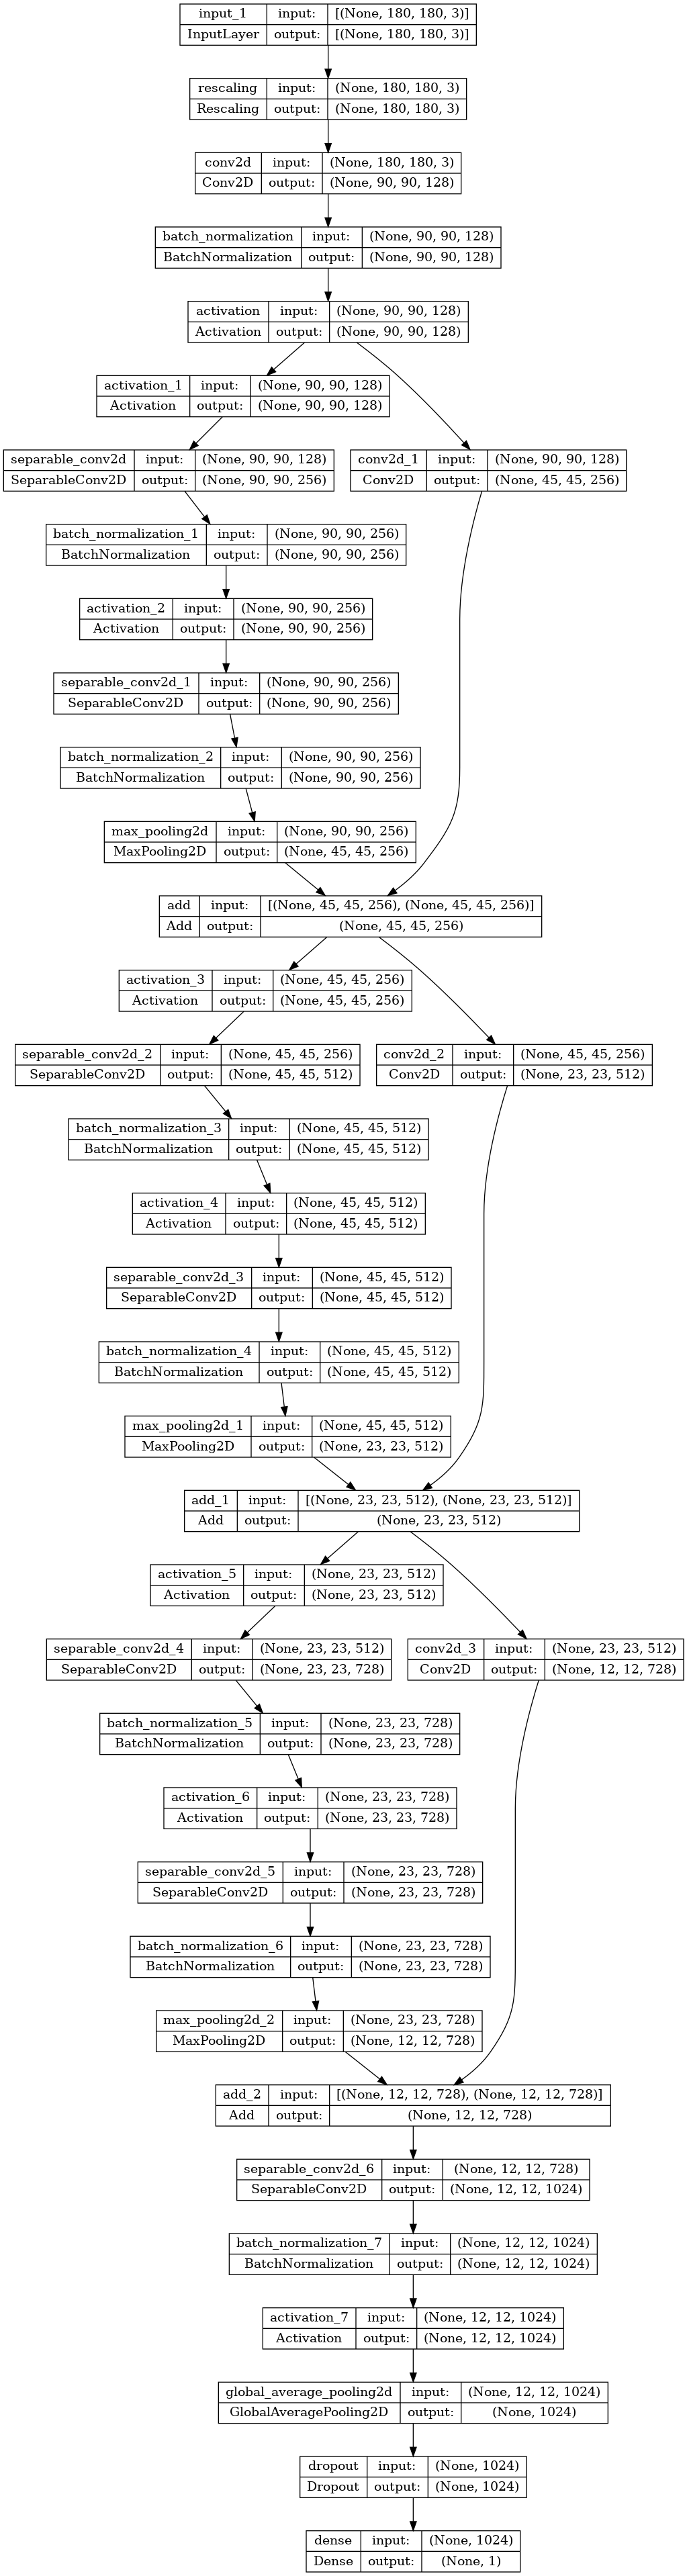

In [ ]:
def make_model(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [ ]:
xception = make_model(input_shape=(180, 180, 3), num_classes=2)

In [ ]:
xception.summary()

### 7.3. Configuración y entrenamiento de la Red Neuronal Artificial

In [ ]:
# Compilamos el modelo
xception.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])

In [ ]:
history = xception.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

### 7.4. Evaluación de los resultados

In [ ]:
# Evaluacmos el modelo con el conjunto de datos de pruebas
evaluation_result = xception.evaluate(test_ds)

# Imprimir las métricas de evaluación (por ejemplo, pérdida y precisión)
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1): # take(1) obtiene un lote del conjunto de datos (128 ejemplos)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = xception.predict(tf.expand_dims(images[i], 0))
        score = float(predictions[0])
        plt.title(f"Cat: {100 * (1 - score):.2f}%, Dog: {100 * score:.2f}%")
        plt.axis("off")

plt.show()